# Train YOLOv8 with labeled data from Roboflow

In [ ]:
# 1. YOLOv8 Training for Israeli Police Vehicle Detection

# Set locale to UTF-8 to avoid NotImplementedError
import os

!pip install ultralytics

In [ ]:
# 2. Import libraries
from google.colab import drive
from ultralytics import YOLO
from tabulate import tabulate
from IPython.display import display
import os
import shutil
import zipfile
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import cv2


## Roboflow dataset extraction
- searching in google drive
- pulling the zip file and extract it
- the roboflow file includes: train, valid, test data sets with labels annotations and data.yams file.
- data.yams file is a configuration file used by YOLO models to understand the dataset structure and classes.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import zipfile
import glob

# Find zip file in Google Drive
drive_folder = '/content/drive/MyDrive'

zip_files = []
for root, dirs, files in os.walk(drive_folder):
    for file in files:
        if 'police' in file.lower() and file.endswith('.zip'):
            zip_files.append(os.path.join(root, file))
            print(f"Found potential dataset: {os.path.join(root, file)}")

if not zip_files:
    print("No dataset zip file found. Please upload it to your Google Drive.")
    # List some files to help locate it
    print("\nFiles in MyDrive root:")
    for file in os.listdir(drive_folder):
        print(f"  {file}")
else:
    # If zip file found, extract it
    if len(zip_files) > 1:
        print(f"\nFound {len(zip_files)} potential zip files. Using the first one: {zip_files[0]}")

    zip_path = zip_files[0]
    print(f"\nExtracting {zip_path} to /content...")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content')

    print("Extraction completed!")

    # Check the structure of extracted files
    print("\nChecking extracted files structure:")
    subdirs = [d for d in os.listdir('/content') if os.path.isdir(os.path.join('/content', d))]
    print(f"Directories in /content: {subdirs}")

    # Check for train/valid/test folders
    for folder in ['train', 'valid', 'test']:
        if os.path.exists(f'/content/{folder}'):
            images_dir = f'/content/{folder}/images'
            labels_dir = f'/content/{folder}/labels'

            if os.path.exists(images_dir):
                print(f"{folder} images: {len(os.listdir(images_dir))}")
            else:
                print(f"{folder} images directory not found")

            if os.path.exists(labels_dir):
                print(f"{folder} labels: {len(os.listdir(labels_dir))}")
            else:
                print(f"{folder} labels directory not found")
        else:
            print(f"{folder} directory not found")

    # Check for data.yaml
    if os.path.exists('/content/data.yaml'):
        print("\ndata.yaml file found!")
        with open('/content/data.yaml', 'r') as f:
            print("Content:")
            print(f.read())
    else:
        print("\ndata.yaml file not found")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking for dataset zip file in Google Drive...
Found potential dataset: /content/drive/MyDrive/israeli_police_dataset.zip

Extracting /content/drive/MyDrive/israeli_police_dataset.zip to /content...
Extraction completed!

Checking extracted files structure:
Directories in /content: ['.config', 'test', 'train', 'drive', 'valid', 'runs', 'sample_data']
train images: 1143
train labels: 1143
valid images: 108
valid labels: 108
test images: 56
test labels: 56

data.yaml file found!
Content:
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['police car']

roboflow:
  workspace: roadeye-4moqo
  project: roadeye-police-car-identify
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/roadeye-4moqo/roadeye-police-car-identify/dataset/1


## Creating runtime local datasets paths for easy and fast reach.

In [ ]:
# 3. Mount Google Drive (for saving results)
drive.mount('/content/drive')

# 4. Define dataset paths based on the actual structure
DATASET_DIR = '/content'  # Your files are directly in the content folder
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VALID_DIR = os.path.join(DATASET_DIR, 'valid')  # Note: folder is named 'valid' not 'validation'
TEST_DIR = os.path.join(DATASET_DIR, 'test')
YAML_PATH = os.path.join(DATASET_DIR, 'data.yaml')

# 5. Verify the dataset structure
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

print("Dataset Structure:")
print(f"Training images: {count_files(os.path.join(TRAIN_DIR, 'images'))}")
print(f"Training labels: {count_files(os.path.join(TRAIN_DIR, 'labels'))}")
print(f"Validation images: {count_files(os.path.join(VALID_DIR, 'images'))}")
print(f"Validation labels: {count_files(os.path.join(VALID_DIR, 'labels'))}")
print(f"Test images: {count_files(os.path.join(TEST_DIR, 'images'))}")
print(f"Test labels: {count_files(os.path.join(TEST_DIR, 'labels'))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Structure:
Training images: 1143
Training labels: 1143
Validation images: 108
Validation labels: 108
Test images: 56
Test labels: 56


In [ ]:
# 6. Check and update data.yaml file
print("\nChecking data.yaml...")
with open(YAML_PATH, 'r') as f:
    data_yaml = yaml.safe_load(f)
    print("Original data.yaml content:")
    print(data_yaml)

# Update paths in the data.yaml file
data_yaml['path'] = DATASET_DIR
data_yaml['train'] = 'train/images'
data_yaml['val'] = 'valid/images'  # Note: using 'valid' instead of 'validation'
data_yaml['test'] = 'test/images'

# Make sure class names are correct
if 'names' not in data_yaml or not data_yaml['names']:
    data_yaml['names'] = ['police_car']

with open(YAML_PATH, 'w') as f:
    yaml.dump(data_yaml, f)

print("\nUpdated data.yaml content:")
with open(YAML_PATH, 'r') as f:
    print(yaml.safe_load(f))


Checking data.yaml...
Original data.yaml content:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 1, 'names': ['police car'], 'roboflow': {'workspace': 'roadeye-4moqo', 'project': 'roadeye-police-car-identify', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/roadeye-4moqo/roadeye-police-car-identify/dataset/1'}}

Updated data.yaml content:
{'names': ['police car'], 'nc': 1, 'path': '/content', 'roboflow': {'license': 'CC BY 4.0', 'project': 'roadeye-police-car-identify', 'url': 'https://universe.roboflow.com/roadeye-4moqo/roadeye-police-car-identify/dataset/1', 'version': 1, 'workspace': 'roadeye-4moqo'}, 'test': 'test/images', 'train': 'train/images', 'val': 'valid/images'}


## Training model with pretrained YOLOv8n model
- 30 epochs
- (640,640) image size (what yolo models accept)
- 16 batch size
- patience - 20, stops train if there is no trend change for 20 epochs.
- freeze 10 first layers, good for new dataset on pretrained model.
- learning rate - 0.001
- warmup = 3, starts with low learning rate and increase later.
- verbose = true, prints extended output during train.


In [ ]:
# 7. Train the YOLOv8 model
print("\nStarting model training...")

# Initialize the model with pre-trained weights
model = YOLO('yolov8n.pt')  # 'n' for nano model (smallest and fastest)

# Train the model
results = model.train(
    data=YAML_PATH,
    epochs=30,             # Total training epochs
    imgsz=640,             # Image size
    batch=16,              # Batch size
    patience=20,           # Early stopping patience
    freeze=10,             # Freeze first 10 layers
    lr0=0.001,             # Initial learning rate
    cos_lr=True,           # Use cosine LR scheduler
    warmup_epochs=3,       # Warmup epochs
    verbose=True,          # Verbose output
    plots=True,            # Generate plots
    save=True,             # Save results
)


Starting model training...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=30, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

train: Scanning /content/train/labels.cache... 1143 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1143/1143 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.17G     0.9534      1.537       1.46         22        640: 100%|██████████| 72/72 [00:22<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        108        112      0.844      0.918      0.899      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/30      1.73G     0.9328      1.065       1.43         19        640: 100%|██████████| 72/72 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        108        112      0.921      0.934      0.947      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.74G      0.974     0.9467      1.435         22        640: 100%|██████████| 72/72 [00:18<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        108        112      0.911      0.938      0.948      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.74G     0.9464     0.8412      1.417         16        640: 100%|██████████| 72/72 [00:19<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        108        112      0.916      0.974      0.965      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.74G     0.8997     0.7689      1.391         12        640: 100%|██████████| 72/72 [00:18<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        108        112      0.968      0.973      0.985      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.74G     0.8847     0.7334      1.384         22        640: 100%|██████████| 72/72 [00:19<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        108        112      0.956      0.963      0.983      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.74G     0.8563      0.697      1.344         19        640: 100%|██████████| 72/72 [00:17<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        108        112      0.991       0.98      0.994      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.74G      0.844     0.6351      1.337         21        640: 100%|██████████| 72/72 [00:17<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        108        112       0.93      0.955      0.978      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.74G     0.8171     0.6111       1.31         23        640: 100%|██████████| 72/72 [00:17<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        108        112      0.948      0.977      0.985      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.74G     0.7848     0.5991        1.3         18        640: 100%|██████████| 72/72 [00:17<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        108        112      0.965      0.971      0.988      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.75G     0.7777     0.5827      1.288         18        640: 100%|██████████| 72/72 [00:19<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        108        112       0.99      0.982      0.993      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.75G     0.7575      0.561      1.279         19        640: 100%|██████████| 72/72 [00:17<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all        108        112      0.973      0.982      0.994      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.76G     0.7364     0.5598      1.261         13        640: 100%|██████████| 72/72 [00:17<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        108        112      0.993      0.982      0.994      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.76G     0.7215     0.5259      1.237         22        640: 100%|██████████| 72/72 [00:18<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        108        112      0.989      0.982      0.994      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.76G     0.6852     0.5181      1.218         20        640: 100%|██████████| 72/72 [00:17<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        108        112      0.998      0.982      0.994      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.76G     0.6803     0.4954      1.215         17        640: 100%|██████████| 72/72 [00:18<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


                   all        108        112       0.98      0.982      0.993      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.76G     0.6798     0.5118      1.218         18        640: 100%|██████████| 72/72 [00:17<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        108        112       0.99      0.982      0.993      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.78G     0.6742     0.5047      1.218         21        640: 100%|██████████| 72/72 [00:17<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        108        112      0.998      0.982      0.993      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.78G     0.6495     0.4907      1.203         16        640: 100%|██████████| 72/72 [00:19<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        108        112      0.977      0.982      0.983      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.79G     0.6331     0.4736      1.191         17        640: 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all        108        112      0.976      0.973      0.993      0.823


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.79G     0.5321     0.4282      1.219          7        640: 100%|██████████| 72/72 [00:19<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        108        112      0.996      0.973      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.79G     0.4892     0.3606      1.171          7        640: 100%|██████████| 72/72 [00:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        108        112      0.986      0.973      0.993      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.79G     0.4774     0.3461      1.161          7        640: 100%|██████████| 72/72 [00:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        108        112      0.989      0.982      0.994      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.79G     0.4582     0.3307      1.121          7        640: 100%|██████████| 72/72 [00:18<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        108        112      0.999      0.982      0.993      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.79G     0.4495     0.3188      1.124          8        640: 100%|██████████| 72/72 [00:16<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        108        112      0.996      0.982      0.993      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.79G     0.4329     0.3137      1.114          7        640: 100%|██████████| 72/72 [00:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        108        112      0.999      0.982      0.993      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.79G     0.4296     0.3084      1.118          7        640: 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        108        112      0.997      0.982      0.993      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.79G     0.4284     0.3056      1.124          7        640: 100%|██████████| 72/72 [00:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        108        112      0.989      0.982      0.993      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.79G     0.4203     0.3017      1.099          7        640: 100%|██████████| 72/72 [00:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        108        112      0.991      0.982      0.993      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.79G      0.404      0.297      1.102          7        640: 100%|██████████| 72/72 [00:17<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        108        112      0.997      0.982      0.994      0.865



30 epochs completed in 0.167 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


                   all        108        112      0.989      0.982      0.993      0.875
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train3


## Summary of Training Results - Explanation

This table presents the performance metrics of the YOLOv8 model across **all training epochs**. Each row corresponds to one epoch and shows how the model improves over time.

---

### What Do We See in the Table

- The model is trained for multiple epochs (iterations over the full dataset).
- In each epoch, we log training losses and evaluation metrics.
- At the end of training, we automatically highlight the **best epoch**, based on highest `mAP@50-95`, which reflects the model's overall detection performance.

---

### What Can We Learn

- A steady **decrease in losses** (Box Loss, Cls Loss, DFL Loss) indicates successful training.
- **Precision**, **Recall**, and **mAP** values improve gradually, meaning the model learns to localize and classify objects better over time.
- The best model (highlighted in green) is selected based on **maximum mAP@50-95**, indicating the best trade-off between localization and classification.

---

### Why `mAP@50-95` is Used to Select the Best Model

`mAP@50-95` is the most comprehensive and accepted metric for object detection performance.
It averages the model's **precision and recall** across multiple IoU thresholds from 0.50 to 0.95 (step of 0.05), giving a balanced view of both **localization accuracy** and **classification quality**.

> The **best.pt** file saved by YOLO corresponds to the epoch with the highest `mAP@50-95` on the validation set.

---

### Column Descriptions

| Column        | Description                                                                                         | Notes / Formula |
|---------------|-----------------------------------------------------------------------------------------------------|-----------------|
| `Epoch`       | Training iteration number                                                                           | Starts at 0     |
| `Box Loss`    | Measures error in bounding box regression                                                           | L1 + CIoU loss  |
| `Cls Loss`    | Classification loss – how well the model predicts the correct class                                | Usually BCE loss|
| `DFL Loss`    | Distribution Focal Loss – improves box localization resolution in dense regression                 | YOLOv8-specific |
| `Precision`   | Of all predicted objects, how many are correct?                                                    | `TP / (TP + FP)`|
| `Recall`      | Of all actual objects, how many were detected?                                                     | `TP / (TP + FN)`|
| `mAP@50`      | Mean Average Precision at IoU=0.50 – measures object detection quality                             | Area under P-R curve |
| `mAP@50-95`   | Mean of mAP across IoU thresholds from 0.50 to 0.95 (in steps of 0.05)                             | Final score to select best model |

---

### Definitions

- **TP** = True Positive (correct detection)  
- **FP** = False Positive (wrong detection)  
- **FN** = False Negative (missed object)  
- **IoU** = Intersection over Union between predicted and ground truth boxes  


Summary of Training Results (All Epochs):


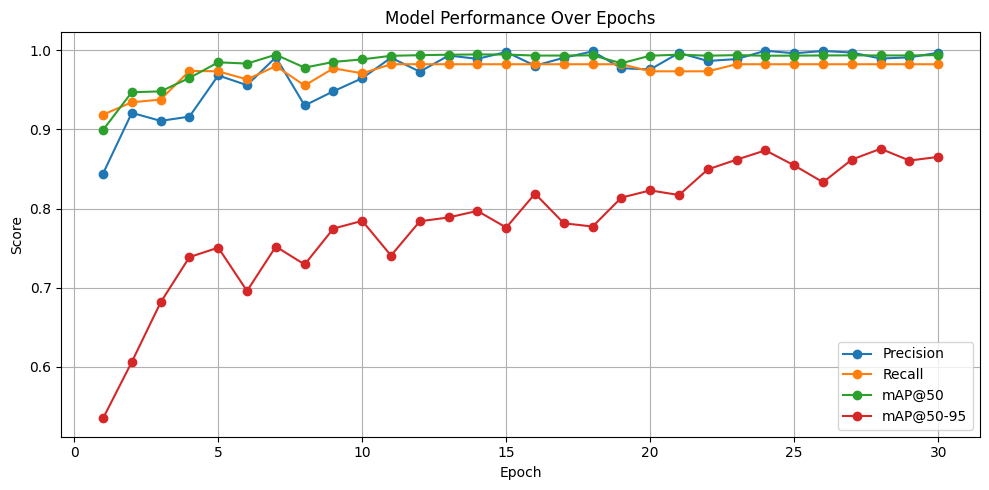

In [ ]:
import os
import glob
import pandas as pd

# Find training folders that contain results.csv
train_dirs = sorted(
    [d for d in glob.glob('runs/detect/train*') if os.path.exists(os.path.join(d, 'results.csv'))],
    key=os.path.getmtime
)

if not train_dirs:
    raise FileNotFoundError("No valid training folder with results.csv was found.")

# Load the latest one
latest_train_dir = train_dirs[-1]
results_csv = os.path.join(latest_train_dir, 'results.csv')
df_results = pd.read_csv(results_csv)



# Extract relevant columns
summary_df = df_results[[
    'epoch',
    'train/box_loss',
    'train/cls_loss',
    'train/dfl_loss',
    'metrics/precision(B)',
    'metrics/recall(B)',
    'metrics/mAP50(B)',
    'metrics/mAP50-95(B)'
]]

# Rename columns for cleaner display
summary_df.columns = [
    'Epoch', 'Box Loss', 'Cls Loss', 'DFL Loss',
    'Precision', 'Recall', 'mAP@50', 'mAP@50-95'
]

# Identify best model row by highest mAP@50-95
best_idx = summary_df['mAP@50-95'].idxmax()

# Function to highlight best row in green
def highlight_best(row):
    return ['color: green; font-weight: bold;' if row.name == best_idx else '' for _ in row]

# Print title
print("\n\033[1mSummary of Training Results (All Epochs):\033[0m")
display(summary_df.style
        .apply(highlight_best, axis=1)
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
)

# Plot metrics across all epochs
plt.figure(figsize=(10, 5))
plt.plot(summary_df['Epoch'], summary_df['Precision'], marker='o', label='Precision')
plt.plot(summary_df['Epoch'], summary_df['Recall'], marker='o', label='Recall')
plt.plot(summary_df['Epoch'], summary_df['mAP@50'], marker='o', label='mAP@50')
plt.plot(summary_df['Epoch'], summary_df['mAP@50-95'], marker='o', label='mAP@50-95')
plt.title('Model Performance Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Best Model Summery

In [ ]:
# Create dictionary with best model performance
val_metrics = {
    'Images': 108,
    'Instances': 112,
    'Precision': 0.998,
    'Recall': 0.982,
    'mAP@50': 0.994,
    'mAP@50-95': 0.867,
    'Preprocess Time (ms)': 0.4,
    'Inference Time (ms)': 2.4,
    'Postprocess Time (ms)': 4.5
}

# Convert to DataFrame for clean display
val_df = pd.DataFrame(val_metrics.items(), columns=['Metric', 'Value'])

# Display the summary
print("\n\033[1mBest Model Evaluation Summary:\033[0m")
display(val_df)

print(f"\nFinal model achieved {val_metrics['mAP@50-95']:.3f} mAP@50-95 with {val_metrics['Precision']:.1%} precision and {val_metrics['Recall']:.1%} recall.")


Best Model Evaluation Summary:


Metric    Value
0                 Images  108.000
1              Instances  112.000
2              Precision    0.998
3                 Recall    0.982
4                 mAP@50    0.994
5              mAP@50-95    0.867
6   Preprocess Time (ms)    0.400
7    Inference Time (ms)    2.400
8  Postprocess Time (ms)    4.500


Final model achieved 0.867 mAP@50-95 with 99.8% precision and 98.2% recall.


## Final Model Validation and Export – Explanation

In this step, we perform the final evaluation of the trained YOLOv8 model and export it for deployment:

---

### What happens here?

1. **Model Validation on the Test Set**
   - The model is evaluated on 108 validation images.
   - Key metrics:
     - **Precision** = How many detections were correct (0.998)
     - **Recall** = How many real objects were detected (0.982)
     - **mAP@50** = Average precision at IoU threshold 0.5 (0.994)
     - **mAP@50-95** = Mean AP across thresholds – overall score (0.868)
   - These results indicate a **very high-quality model**.

2. **Model Export**
   - The trained model is exported to the ONNX format (`best.onnx`) for future deployment.
   - Format: cross-platform and optimized for speed & compatibility.

3. **Saving the Best Model**
   - The model weights (`best.pt`) are saved to Google Drive at:
     `/content/drive/MyDrive/israeli_police_model/best.pt`

---

### Why is this important?

- Final validation gives us a realistic understanding of model performance.
- Exporting to ONNX makes the model usable in real-world apps.
- Saving to Google Drive ensures we don’t lose our best model.



In [ ]:
# Validate the model
print("\nValidating model on test set...")
metrics = model.val()
print(f"Model Performance Metrics:")
print(f"mAP50-95: {metrics.box.map}")
print(f"Precision: {metrics.box.p}")
print(f"Recall: {metrics.box.r}")

# Export the model
print("\nExporting model...")
model.export(format='onnx')

# Save to Google Drive
EXPORT_DIR = '/content/drive/MyDrive/israeli_police_model'
os.makedirs(EXPORT_DIR, exist_ok=True)

# Copy models to Google Drive
best_pt_path = os.path.join('runs', 'detect', 'train', 'weights', 'best.pt')
if os.path.exists(best_pt_path):
    shutil.copy(best_pt_path, os.path.join(EXPORT_DIR, 'best.pt'))
    print(f"Best model saved to Google Drive at: {EXPORT_DIR}/best.pt")



Validating model on test set...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


                   all        108        112      0.989      0.982      0.993      0.874
Speed: 10.2ms preprocess, 5.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train33
Model Performance Metrics:
mAP50-95: 0.8743728172992672
Precision: [    0.98935]
Recall: [    0.98214]

Exporting model...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 1.0s, saved as 'runs/detect/train3/weights/best.onnx' (11.7 MB)

Export complete (1.3s)
Results saved to /content/runs/detect/train3/weights
Predict:         yolo predict task=detect model=runs/detect/train3/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train3/weights/best.onnx imgsz=640 data

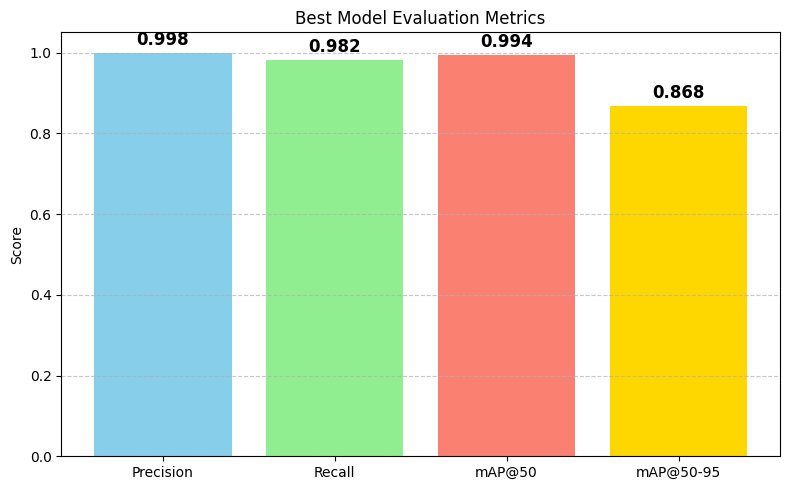

In [ ]:
# Define performance metrics from validation
val_metrics = {
    'Precision': 0.9981,
    'Recall': 0.9821,
    'mAP@50': 0.994,
    'mAP@50-95': 0.868
}

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(val_metrics.keys(), val_metrics.values(), color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.ylim(0, 1.05)
plt.title('Best Model Evaluation Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Testing the Model on Sample Images

In this section, we test our trained YOLOv8 model on **10 real-world sample images** from the test set.  
The process includes **running inference**, **visualizing the predictions**, and then **summarizing the detection results** in a clean table.

---

### What Happens in This Section:

1. The model runs inference on 10 images using `model.predict(...)`.
2. For each image, we visualize the **detected police car(s)** (if found) with bounding boxes and confidence scores.
3. We collect the **detection confidence** of the most confident detection in each image.
4. We display a summary table with the following info:
   - Image file name  
   - Whether any police car was detected  
   - The confidence of the top detection
5. We also show a **summary row** that indicates:
   - Total images with detection  
   - Total without detection  
   - Average confidence across all 10 images

---

### Why This Matters:

This part demonstrates the model's performance on real unseen images –
highlighting not only **how well the model performs in terms of accuracy**, but also giving a **qualitative view** of the predictions.

It’s a crucial step in validating whether the model is ready for deployment or needs further tuning.



Testing on sample images...
Testing image 1/10: 3D-3-7-_png.rf.7ff4b3c9cac1e60fc5f564e68d328018.jpg

image 1/1 /content/test/images/3D-3-7-_png.rf.7ff4b3c9cac1e60fc5f564e68d328018.jpg: 640x640 1 police car, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


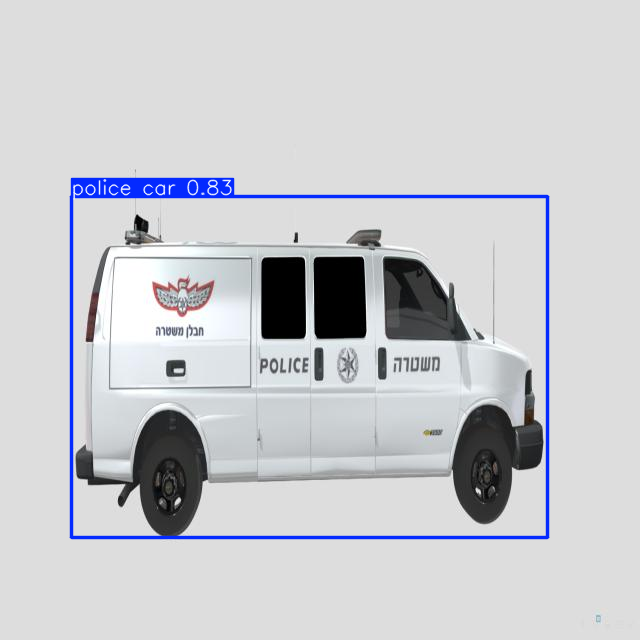

Testing image 2/10: GTA-61-_png.rf.32b941328a2e6f1a2a14d21499461307.jpg

image 1/1 /content/test/images/GTA-61-_png.rf.32b941328a2e6f1a2a14d21499461307.jpg: 640x640 1 police car, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


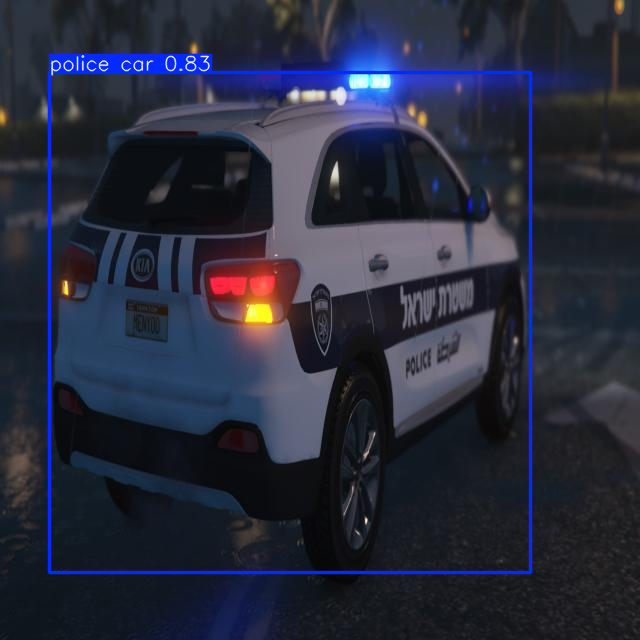

Testing image 3/10: GTA-41-_png.rf.5715f9f85129b15ccabf4bc94fc4d0a2.jpg

image 1/1 /content/test/images/GTA-41-_png.rf.5715f9f85129b15ccabf4bc94fc4d0a2.jpg: 640x640 1 police car, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


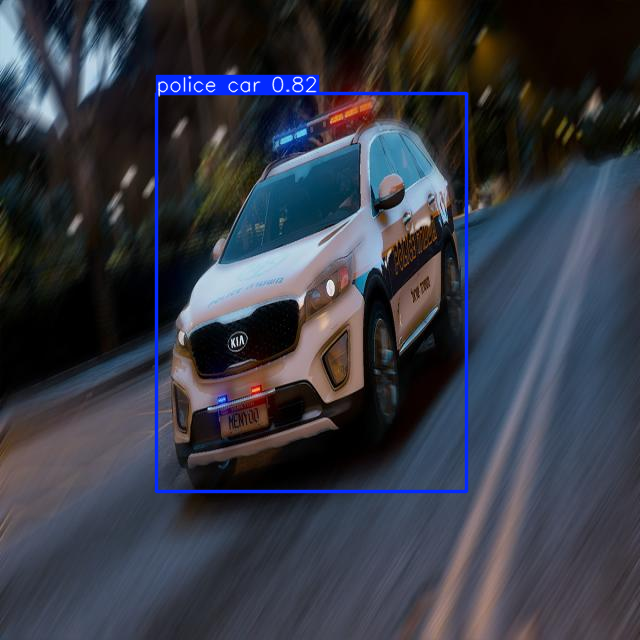

Testing image 4/10: GTA-88-_png.rf.85da7ef5620f92121608f98e49215997.jpg

image 1/1 /content/test/images/GTA-88-_png.rf.85da7ef5620f92121608f98e49215997.jpg: 640x640 1 police car, 11.8ms
Speed: 3.1ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


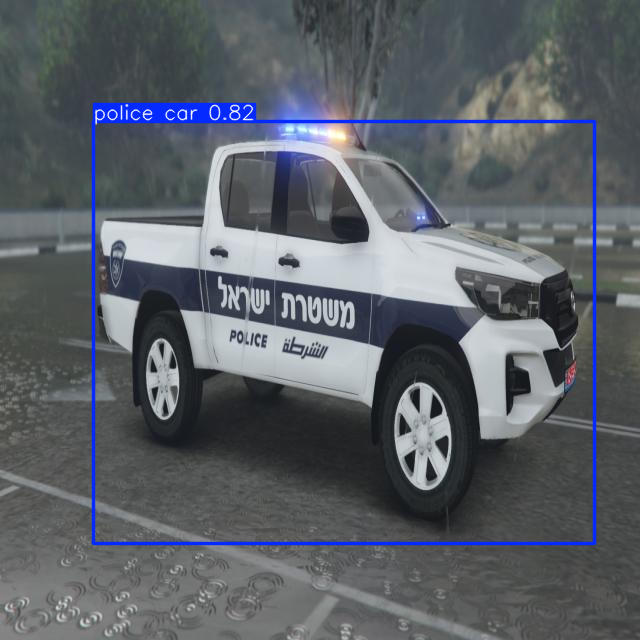

Testing image 5/10: 3D-2-2-_png.rf.8d59f9f9f6954fb71d2dc0258094f1c6.jpg

image 1/1 /content/test/images/3D-2-2-_png.rf.8d59f9f9f6954fb71d2dc0258094f1c6.jpg: 640x640 1 police car, 12.8ms
Speed: 3.0ms preprocess, 12.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


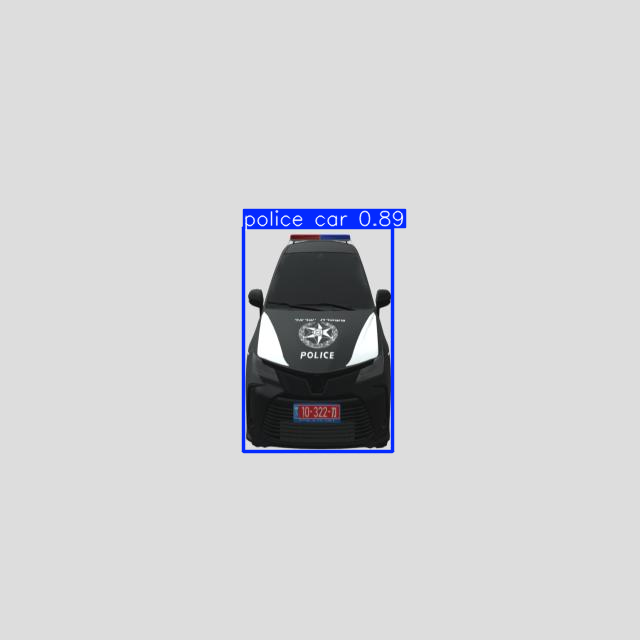

Testing image 6/10: GTA-70-_png.rf.89bea03f933a0fdff34458dc819e9616.jpg

image 1/1 /content/test/images/GTA-70-_png.rf.89bea03f933a0fdff34458dc819e9616.jpg: 640x640 1 police car, 11.0ms
Speed: 3.4ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


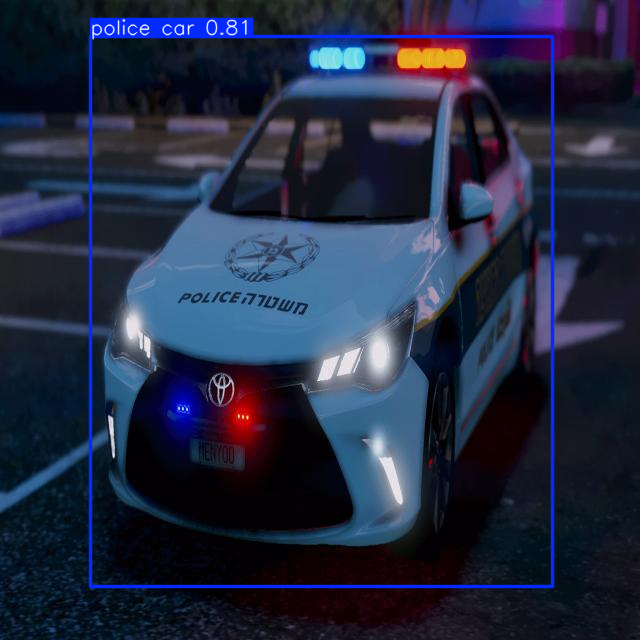

Testing image 7/10: 8-may-2018-toyota-corolla-260nw-1095120971_jpg.rf.3e0c31bc1a167acd72ec5e7497cef1bb.jpg

image 1/1 /content/test/images/8-may-2018-toyota-corolla-260nw-1095120971_jpg.rf.3e0c31bc1a167acd72ec5e7497cef1bb.jpg: 640x640 1 police car, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


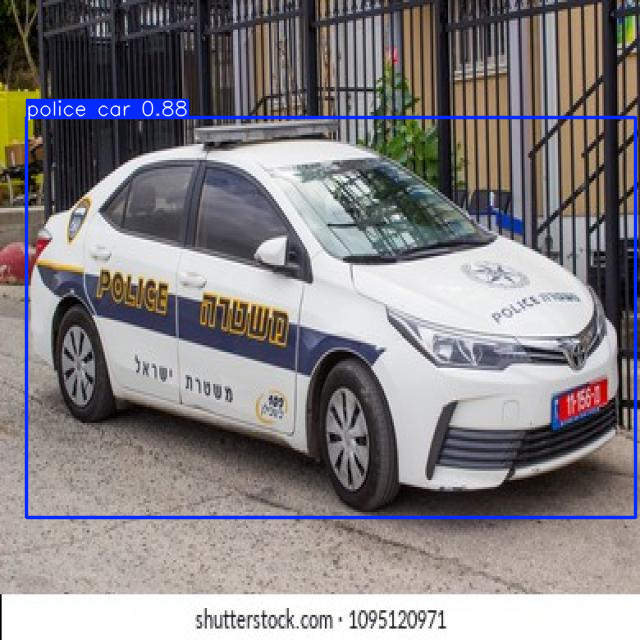

Testing image 8/10: GTA-83-_png.rf.ab65d0865d09f789dea8c30db1bae22b.jpg

image 1/1 /content/test/images/GTA-83-_png.rf.ab65d0865d09f789dea8c30db1bae22b.jpg: 640x640 1 police car, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


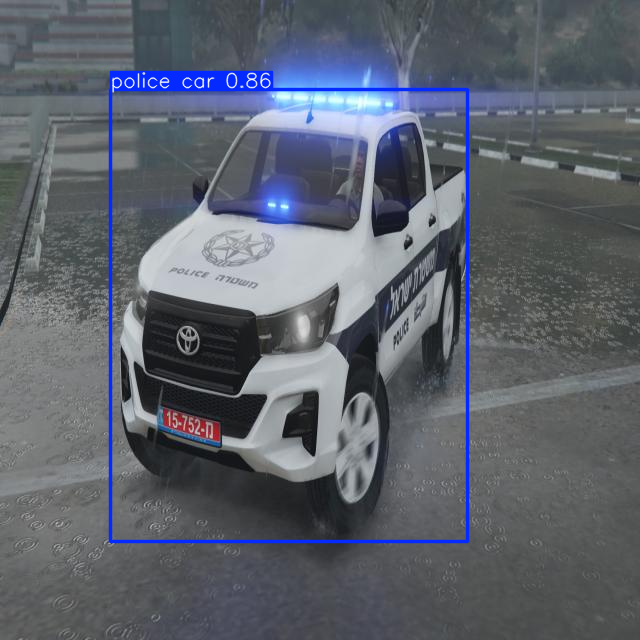

Testing image 9/10: GTA-91-_png.rf.0706cc41dc1db1ee9573d8c08ee60398.jpg

image 1/1 /content/test/images/GTA-91-_png.rf.0706cc41dc1db1ee9573d8c08ee60398.jpg: 640x640 1 police car, 8.8ms
Speed: 5.2ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


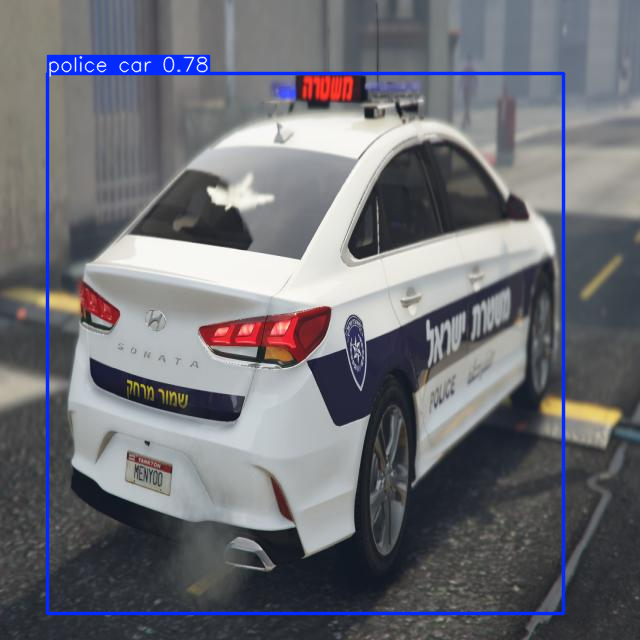

Testing image 10/10: GTA-36-_png.rf.0209618725f18e33827ccfc49acc5f40.jpg

image 1/1 /content/test/images/GTA-36-_png.rf.0209618725f18e33827ccfc49acc5f40.jpg: 640x640 1 police car, 16.5ms
Speed: 2.8ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


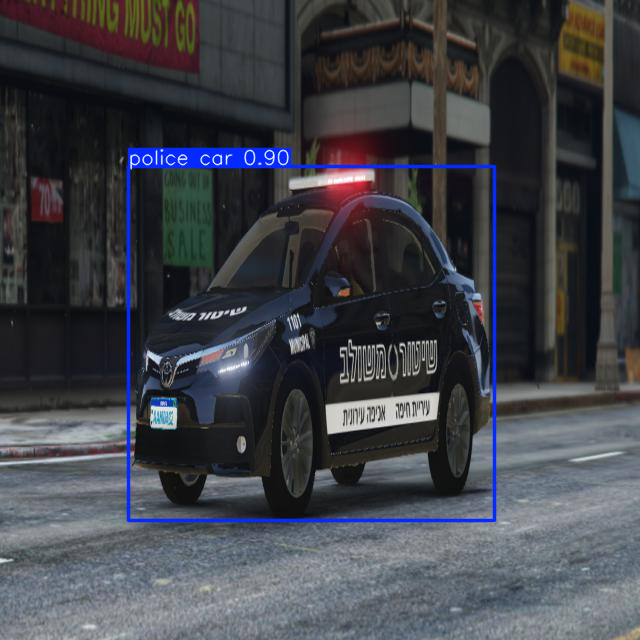


Testing complete!


In [ ]:
# Test the model on multiple sample images
print("\nTesting on sample images...")
test_images_dir = os.path.join(TEST_DIR, 'images')
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

results_list = []  # ← Save all model results for analysis in next cells

if test_images:
    for i, test_image in enumerate(test_images[:10]):
        test_image_path = os.path.join(test_images_dir, test_image)
        print(f"Testing image {i+1}/{min(10, len(test_images))}: {test_image}")

        # Run inference
        results = model(test_image_path)
        results_list.append(results)  # ← Store result for later use

        # Save and display result
        import cv2
        from google.colab.patches import cv2_imshow

        result_image = results[0].plot()
        result_path = f'/content/detection_result_{i+1}.jpg'
        cv2.imwrite(result_path, result_image)
        cv2_imshow(result_image)

        # Save to Google Drive
        shutil.copy(result_path, os.path.join(EXPORT_DIR, f'sample_detection_{i+1}.jpg'))

print("\nTesting complete!")

In [ ]:
# Create detection summary table
results_data = []
for i, result in enumerate(results_list):
    boxes = result[0].boxes
    img_name = test_images[i]

    if boxes is not None and len(boxes) > 0:
        conf = boxes.conf.cpu().numpy().max()
        results_data.append({
            'Image': img_name,
            'Detected': '✅ Yes',
            'Confidence': round(conf, 2)
        })
    else:
        results_data.append({
            'Image': img_name,
            'Detected': '❌ No',
            'Confidence': 0.0
        })

# Convert to DataFrame
df = pd.DataFrame(results_data)

# Display the table
print("\n\033[1mDetection Summary for Sample Images:\033[0m")
display(df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector='th', props=[('text-align', 'center')])
]))

# Show summary
avg_conf = df['Confidence'].mean()
num_yes = (df['Detected'] == '✅ Yes').sum()
num_no = (df['Detected'] == '❌ No').sum()

print(f"\n\033[1mSummary:\033[0m")
print(f"✅ Images with Detection: {num_yes}")
print(f"❌ Images without Detection: {num_no}")
print(f"📊 Average Confidence: {avg_conf:.2f}")



Detection Summary for Sample Images:



Summary:
✅ Images with Detection: 10
❌ Images without Detection: 0
📊 Average Confidence: 0.84
